In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import Simulation
from committee_learning.result import SimulationResult
import numpy as np
from itertools import product

d_list = [100,1000, 10000]
d_list = [100,1000,2500,5000,7500,10000,12500,15000,20000,25000,40000,50000]
p_list = [1]#,8,16]
k = 1
gamma0 = .1
noise = 1e-3
log_time = 2.
sigma = 0.01
exit_threshold = 0.02

def id_range(d):
  return range(0,int(13000/np.sqrt(d)))

param_list = [(p,d,id) for p,d in list(product(p_list,d_list)) for id in id_range(d)]
# ics = {(p,d) : PhaseDiagramInitialConditions(p,k,True) for p,d in product(p_list,d_list)}
ics = {(p,d,id) : RandomNormalInitialConditions(p,k,d,sigma=sigma,seed=id) for p,d,id in param_list}

### Simulations

In [4]:
from tqdm import tqdm
simrs = {}

for key, ic in tqdm(ics.items()):
  p,d,id = key
  # print(f'Simulating d = {d}, p = {p}, id = {id}')
  # Wteacher, W0 = ic.weights(d)
  Wteacher = ic.Wteacher
  W0 = ic.W0
  sim = Simulation(d,p,k,noise,Wteacher,gamma0,'square',W0)
  simr = SimulationResult(initial_condition=f'random{sigma:.2e}',id=id)
  simr.from_file_or_run(sim,log_time+np.log10(sim.d),path='computation-database/sim/')
  simrs[(p,d,id)] = simr

100%|██████████| 2952/2952 [25:31<00:00,  1.93it/s]    


In [5]:
averaged_simulations = {}
averaged_qm = {}
exit_point_q = {}
exit_point_m = {}
for d in d_list:
  for p in p_list:
    data = []
    dataq = []
    datam = []
    datap = []
    how_many_different = set()
    for id in id_range(d):
      how_many_different.add(tuple(simrs[(p,d,id)].risks))
      try:
        assert(simrs[(p,d,1)].steps == simrs[(p,d,id)].steps)
      except:
        print(simrs[(p,d,1)].steps, simrs[(p,d,id)].steps)
        print(d)
      if np.isnan(np.array(simrs[(p,d,id)].risks)).any():
        continue
      data.append(np.array(simrs[(p,d,id)].risks))
      dataq.append(np.array(simrs[(p,d,id)].Qs))
      datam.append(abs(np.array(simrs[(p,d,id)].Ms)))
      datap.append(np.array(simrs[(p,d,id)].P))
    print(f'How many different runs d={d}, p={p}: {len(how_many_different)}')
    data = np.array(data)
    dataq = np.array(dataq)
    datam = np.array(datam)
    datap = np.array(datap) 
    print(d,data.shape)
    average = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    averaged_simulations[(p,d)] = (simrs[(p,d,1)].steps, average, std)
    mean_Q = np.squeeze(np.mean(dataq, axis=0))
    mean_M = np.squeeze(np.mean(datam,axis=0))
    averaged_qm[(p,d)] = (simrs[(p,d,1)].steps, mean_Q, mean_M, np.mean(datap,axis=0))

    # exit_point[(p,d)] = simrs[(p,d,1)].steps[np.argmin(mean_Q)]
    exit_point_m[(p,d)] = simrs[(p,d,1)].steps[np.argmax(mean_M>exit_threshold)]
    exit_point_q[(p,d)] = simrs[(p,d,1)].steps[np.argmax(mean_Q>exit_threshold)]


How many different runs d=100, p=1: 1300
100 (1296, 300)
How many different runs d=1000, p=1: 411
1000 (411, 400)
How many different runs d=2500, p=1: 260
2500 (260, 500)
How many different runs d=5000, p=1: 183
5000 (183, 500)
How many different runs d=7500, p=1: 150
7500 (150, 500)
How many different runs d=10000, p=1: 130
10000 (130, 500)
How many different runs d=12500, p=1: 116
12500 (116, 600)
How many different runs d=15000, p=1: 106
15000 (106, 600)
How many different runs d=20000, p=1: 91
20000 (91, 600)
How many different runs d=25000, p=1: 82
25000 (82, 600)
How many different runs d=40000, p=1: 65
40000 (65, 600)
How many different runs d=50000, p=1: 58
50000 (58, 600)


### Plot

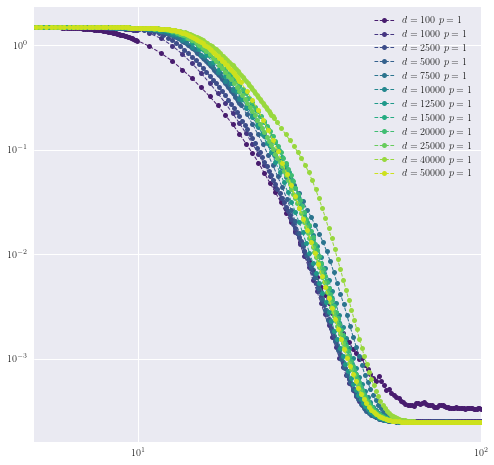

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from committee_learning.utilities import plot_style

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_prop_cycle(color=sns.color_palette("viridis",len(d_list)))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(5,1e2)
  # ax.set_xlim(0,100)
  for key, simr in averaged_simulations.items():
    p,d = key
    # if d != 100:
    #   continue
    steps, risks, rstd = simr
    t = np.array(steps) / d
    # ax.errorbar(t, risks, rstd, label=f'$d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax.plot(t, risks, label=f'$d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    # ax.plot(oders[d].times, oders[d].risks, label='ODE')
  ax.legend()
  plt.show()
  


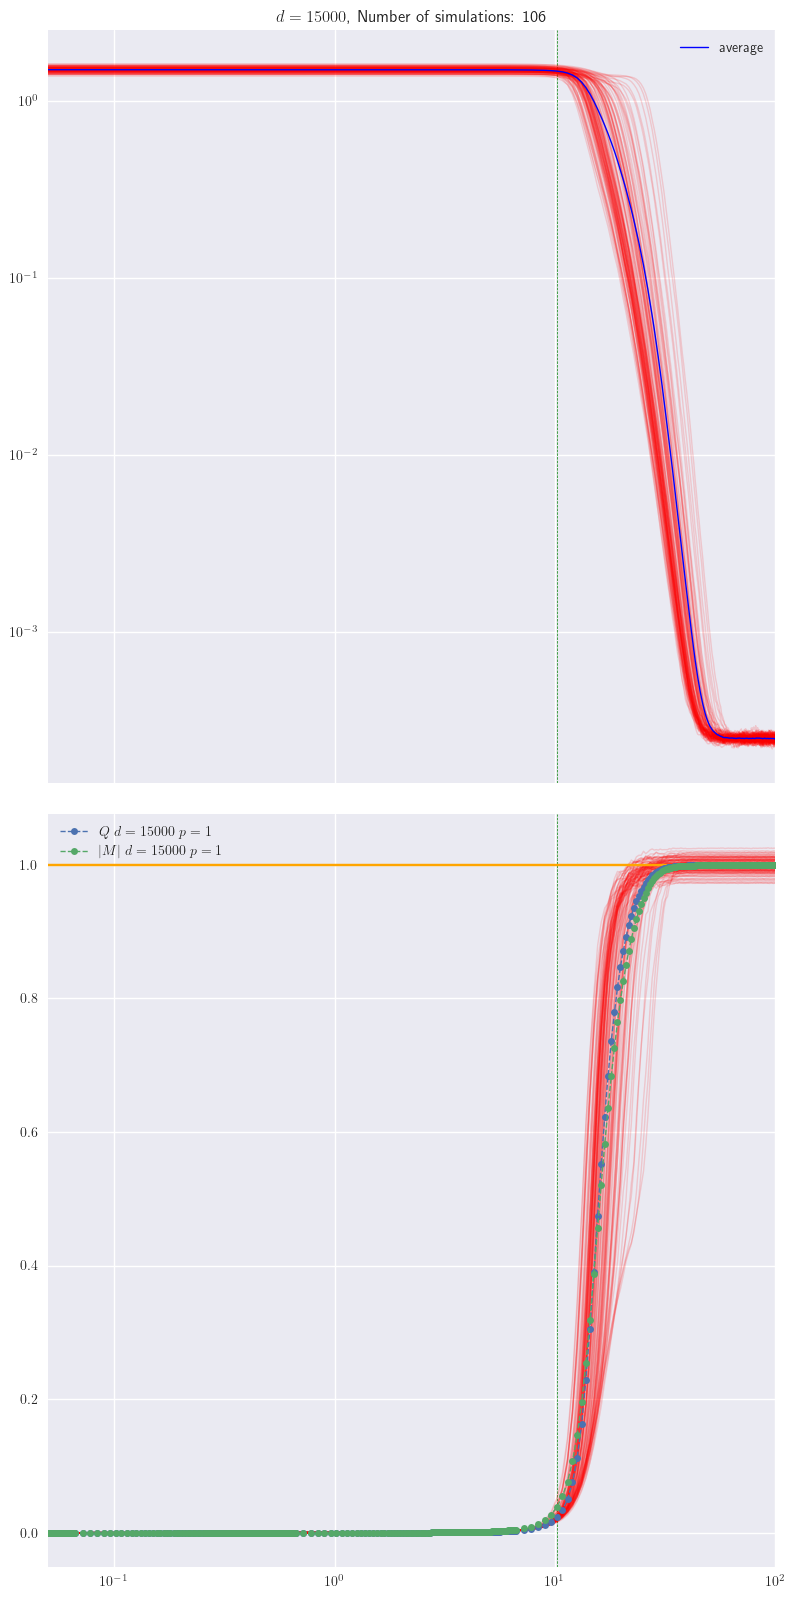

In [7]:
fixed_d = 15000
with plot_style():
  fig, (ax_up, ax_down) = plt.subplots(2,1, figsize=(8,16),sharex=True)
  fig.tight_layout()
  ax_up.set_xscale('log')
  ax_up.set_xlim(1e-3,1e2)
  ax_up.set_xlim(0.05,1e2)
  # ax_up.set_xlim(8,1e1)
  # ax_down.set_ylim(-0.01,0.1)

  ax_up.axvline(exit_point_q[(1,fixed_d)]/fixed_d, lw=.5, ls='--',c='green')
  ax_down.axvline(exit_point_q[(1,fixed_d)]/fixed_d, lw=.5, ls='--',c='green')

  ax_up.set_yscale('log')
  cnt = 0
  for key, simr in simrs.items():
    p,d,id = key
    if d != fixed_d:
      continue
    if np.isnan(np.array(simr.risks)).any():
      continue
    cnt +=1
    t = np.array(simr.steps) / d
    ax_up.plot(t, simr.risks,ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.00125*np.sqrt(fixed_d))
    ax_down.plot(t, np.squeeze(np.array(simr.Qs)),ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.00125*np.sqrt(fixed_d))

  steps, risks, rstd = averaged_simulations[(1,fixed_d)]
  ax_up.plot(t, risks, label=f'average',ls='-',lw=1.,marker='',ms=2.,c='b')
  ax_up.set_title(f'$d={fixed_d}$, Number of simulations: {cnt}')
  ax_up.legend()

  # ax_down.set_yscale('log')
  for key, simr in averaged_qm.items():
    p,d = key
    if d != fixed_d:
      continue
    steps, Qs, Ms, P = simr
    Qs = np.squeeze(np.array(Qs))
    Ms = np.squeeze(abs(np.array(Ms)))
    P  = np.squeeze(np.array(P))
    t = np.array(steps) / d
    ax_down.axhline(P, c='orange')
    ax_down.plot(t, Qs, label=f'$Q$ $d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax_down.plot(t, Ms, label=f'$|M|$ $d={d}$ $p={p}$',ls='--',lw=1.,marker='o',ms=5.)
    ax_down.legend()
  
  plt.show()

## Exit point estimation

### M exit

In [42]:
from scipy.optimize import curve_fit
ds = np.array(d_list, dtype=np.float64)
eps = np.array([exit_point_m[(1,d)] for d in d_list], dtype=np.float64)
eps /= ds

def loglogline(x,a,C):
  return C*(x**a)

def log(x,a,C):
  return C*np.log(a*x)

def theoretical_m_exit(d):
  return 1./(6*gamma0) * np.log(exit_threshold*np.sqrt(2*d/2)/sigma)

param_line, cov = curve_fit(loglogline, ds, eps)
a_line, C_line = param_line

param_log, cov = curve_fit(log, ds, eps)
a_log, C_log = param_log

with plot_style():
  fig, ax = plt.subplots(figsize=(2.75,2.75))
  ax.set_xscale('log')
  # ax.set_yscale('log')
  ax.set_xlabel(r'$d$')
  ax.set_ylabel(r'$t_\text{ex}^{(m)}$')

  linspace = np.linspace(80, max(d_list), 100)
  # ax.plot(linspace, loglogline(linspace,*param_line), label = f'power: $a={a_line:.3f}$, $C={C_line:.3f}$')
  # ax.plot(linspace, log(linspace,*param_log), label = f'logarithmic: $a={a_log:.3f}$, $C={C_log:.3f}$')
  ax.plot(linspace, theoretical_m_exit(linspace), label = r'theoretical')

  ax.plot(ds, eps, marker='o',ls='', label=r'measured',ms=5.)
  ax.legend()
  fig.savefig('figures/sigma-phase-retrivial-mexit.pdf',bbox_inches="tight")
  

### Q exit


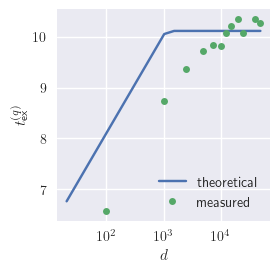

In [48]:
eps = np.array([exit_point_q[(1,d)] for d in d_list], dtype=np.float64)
eps /= ds

def theoretical_q_exit(d):
  return np.minimum(
    # 1./(12.*gamma0) * np.log(exit_threshold*d*(8*gamma0-12*gamma0**2-noise)/(8*gamma0+48*gamma0**2)/(sigma**2)),
    1./(12.*gamma0) * np.log(np.pi/2*exit_threshold/(sigma**2)*d*(8*gamma0-12*gamma0**2+4*noise)/(8*gamma0+48*gamma0**2)),
    1./(4*gamma0+12*gamma0**2+4*noise) * np.log(exit_threshold/(sigma**2))
  )


param_line, cov = curve_fit(loglogline, ds, eps)
a_line, C_line = param_line

param_log, cov = curve_fit(log, ds, eps)
a_log, C_log = param_log

with plot_style():
  fig, ax = plt.subplots(figsize=(2.75,2.75))
  ax.set_xscale('log')
  # ax.set_yscale('log')
  ax.set_xlabel(r'$d$')
  ax.set_ylabel(r'$t_\text{ex}^{(q)}$')
  linspace = np.linspace(20, max(d_list), 100)
  # ax.plot(linspace, loglogline(linspace,*param_line), label = f'power: $a={a_line:.3f}$, $C={C_line:.3f}$')
  # ax.plot(linspace, log(linspace,*param_log), label = f'logarithmic: $a={a_log:.3f}$, $C={C_log:.3f}$')
  ax.plot(linspace, theoretical_q_exit(linspace), label = r'theoretical')

  ax.plot(ds, eps, marker='o',ls='',label=r'measured',ms=5.)
  ax.legend()
  # fig.savefig('figures/sigma-phase-retrivial-qexit.pdf',bbox_inches="tight")
  plt.show()

In [10]:
print(abs(averaged_qm[(1,50000)][1][0]-sigma**2)/sigma**2)
print(eps)

0.00032611326555365746
[ 6.57  8.73  9.36  9.72  9.84  9.81 10.08 10.2  10.35 10.08 10.35 10.26]
